# Numerical Methods Individual Project
# Conor Dunne 

In [1]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy

# Introduction

We investigate the various methods of pricing amercian options, calls and puts, with and without the presence of dividends. The methods employed are the binomial tree pricing, aswell as explicit and implicit finite-difference methods. We further use various implicit methods, including the LU-decompostition, the Gauss-Seidel emthod, and finally the Gauss-Seidel method with successive over relaxation.

# Methodology

## Black-Scholes European Option Pricing

In [2]:
def bs_price(S, K, r, T, sigma, option = 'call'):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if option == 'call':
        result = (S*si.norm.cdf(d1, 0.0, 1.0) - K*np.exp(-r*T)*si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K*np.exp(-r*T)*si.norm.cdf(-d2, 0.0, 1.0) - S*si.norm.cdf(-d1, 0.0, 1.0))
    return result

## Binomial Tree American Option Pricing

In [3]:
def Binomial_American_Option_Dividend(S, K, r, T, sigma, dividend=0, dividend_time=0, n=1000, option='call'): 
    deltaT=T/n
    u=np.exp(sigma * np.sqrt(deltaT))
    d=1.0 / u
    a = np.exp(r*deltaT)
    q=(a-d) / (u-d)
    Sv = np.zeros((n,n))
    V = np.zeros((n,n))
    # Build stock price matrix forward 
    for j in range(n):
        for i in range(j+1):
            #Account for dividend
            Sv[i,j] = (S-S*dividend*np.exp(-r * (T - dividend_time)))*(u**i)*(d**(j-i))
                
            
                
            
            
    if option == 'call': 
        CorP = 1
    elif option == 'put': 
        CorP = -1
    V[:,:] = np.maximum((Sv[:,:]-K)*CorP,0)
    # Price option with backward induction 
    for j in reversed(range(n-1)):
        for i in range(j+1): 
            V[i,j]=np.maximum(V[i,j],np.exp(-r*deltaT)*(q*V[i+1,j+1]+(1.0-q)*V[i,j+1]))
    return V[0,0]

## Explicit Finite-Difference Method American Option Pricing

In [4]:
def American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option='put', dividend_time=0, dividend=0):
    M = int(np.round(Smax/dS))
    dS = Smax/M
    N = int(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    PV_dividend = S*dividend* np.exp(-r * (T - dividend_time))
    if option == 'put':
        V[:,-1] = np.maximum(K-Sv+PV_dividend,0)
        V[0,:] = (K)*np.exp(-r*dt*(N-jv))
        V[M,:] = 0
        sign = -1
    elif option == 'call':
        V[:,-1] = np.maximum(Sv - PV_dividend -K,0)
        V[0,:] = 0
        V[M,:] = Smax - K*np.exp(-r*dt*(N-jv))
        sign = 1
    
    a = 0.5*dt*((sigma**2)*iv - r)*iv
    b = 1-dt*((sigma**2)*(iv**2) + r)
    c = 0.5*dt*((sigma**2)*iv + r)*iv
    
    for j in reversed(np.arange(N)):
        for i in np.arange(1,M): # i goes from 1,..., M-1
            V[i,j] = np.maximum(a[i]*V[i-1,j+1]+b[i]*V[i,j+1]+c[i]*V[i+1,j+1],(Sv[i]-K-PV_dividend)*sign)
            
    f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation
    price = f_interp(S) # Scipy interpolation
    return [Sv, V[:,0], price]

## Implicit Finite-Difference Methods for American Option Pricing

### LU-Decomposition

In [5]:
def American_Option_Implicit_LU(S, K, r, T, sigma, Smax, dS, dt, option='put'):
    M = int(np.round(Smax/dS))
    dS = Smax/M
    N = int(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    #Set up boundary conditions
    if option == 'put':
        V[:,-1] = np.maximum(K-Sv,0)
        V[0,:] = K*np.exp(-r*dt*(N-jv))
        V[M,:] = 0
        sign = -1
    elif option == 'call':
        V[:,-1] = np.maximum(Sv-K,0)
        V[0,:] = 0
        V[M,:] = Smax - K*np.exp(-r*dt*(N-jv))
        sign = 1
    
    # Set up tridiagonal coefficient matrix
    a = -0.5*dt*((sigma**2)*iv - r)*iv
    b = 1+dt*((sigma**2)*(iv**2) + r)
    c = -0.5*dt*((sigma**2)*iv + r)*iv
    
    coef_mat =np.diag(a[2:M],-1)+np.diag(b[1:M])+np.diag(c[1:M-1],1)
    LU, P = scipy.linalg.lu_factor(coef_mat)
    bc = np.zeros(M-1)
    
    for j in reversed(np.arange(N)):
        bc[0] = -a[1]*V[0,j]
        bc[M-2] = -c[M-1]*V[M,j]
    # Solve linear system A*V[1:M-1,j] = b with LU
        V[1:M,j] = scipy.linalg.lu_solve((LU, P),V[1:M,j+1]+bc)
        V[1:M,j] = np.maximum(V[1:M,j],sign*(Sv[1:M]-K))
        
    f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation
    price = f_interp(S) # Scipy interpolation
    return [Sv, V[:,0], price]

### Gauss-Seidel

In [6]:
def GaussSeidel(A, b, x0, epsil, MaxIter, exercise):
    x = x0
    N = len(b)
  
    for k in range(1,MaxIter):
        x_new = np.zeros(N)
        for i in range(N):
            s1 = np.dot(A[i, :i], x_new[:i])
            s2 = np.dot(A[i, i+1:], x[i+1:])
            x_new[i] = np.maximum(exercise[i],(b[i] - s1 - s2)/A[i,i])
        if np.allclose(x, x_new, rtol=epsil):
            break
        x=x_new    
    return x

In [7]:
def American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option='put', dividend_time=0, dividend=0):
    M = int(np.round(Smax/dS))
    dS = Smax/M
    N = int(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    PV_dividend = S*dividend*np.exp(-r * (T - dividend_time))
    #Set up boundary conditions
    if option == 'put':
        V[:,-1] = np.maximum(K-Sv+PV_dividend,0)
        V[0,:] = K*np.exp(-r*dt*(N-jv))
        V[M,:] = 0
        sign = -1
    elif option == 'call':
        V[:,-1] = np.maximum(Sv-K-PV_dividend,0)
        V[0,:] = 0
        V[M,:] = Smax - K*np.exp(-r*dt*(N-jv))
        sign = 1
    
    # Set up tridiagonal coefficient matrix
    a = -0.5*dt*((sigma**2)*iv - r)*iv
    b = 1+dt*((sigma**2)*(iv**2) + r)
    c = -0.5*dt*((sigma**2)*iv + r)*iv
    
    coef_mat =np.diag(a[2:M],-1)+np.diag(b[1:M])+np.diag(c[1:M-1],1)
    LU, P = scipy.linalg.lu_factor(coef_mat)
    bc = np.zeros(M-1)
    
    for j in reversed(np.arange(N)):
        bc[0] = -a[1]*V[0,j] + PV_dividend
        bc[M-2] = -c[M-1]*V[M,j] + PV_dividend
    # Solve linear system A*V[1:M-1,j] = b with LU
        # Solve linear system A*V[1:M-1,j] = b with Gauss Seidel
        exercise = sign*(Sv[1:M]-K - PV_dividend)
        
        V[1:M, j] = GaussSeidel(coef_mat, V[1:M, j+1] + bc, np.zeros((M-1,1)), epsil, MaxIter,exercise)
        #Early exercise option in valuation 
        #for m in range(0,M):
            #V[m,j]=np.maximum(sign*(Sv[m]-K),V[m,j])
            
    f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation
    price = f_interp(S) # Scipy interpolation
    return [Sv, V[:,0], price]

### Gauss-Seidel with Successive Over Relaxation

In [8]:
def SORGaussSeidel(A, b, x0, omega, epsil, MaxIter, exercise):
    x = x0
    N = len(b)
    for k in range(1,MaxIter):
        x_new = np.zeros(N)
        for i in range(N):
            s1 = np.dot(A[i, :i], x_new[:i])
            s2 = np.dot(A[i, i+1:], x[i+1:])
            z = (b[i] - s1 - s2)/A[i,i]
            x_new[i] = np.maximum(exercise[i],omega*z + (1-omega)*x[i])
        if np.allclose(x, x_new, rtol=epsil):
            break
        x = x_new
    return [x,k]

In [9]:
def American_Option_Implicit_GS_SOR(S, K, r, T, sigma, Smax, dS, dt, omega, epsil, MaxIter, option='put'):
    M = int(np.round(Smax/dS))
    dS = Smax/M
    N = int(np.round(T/dt))
    dt = T/N
    V = np.zeros((M+1,N+1))
    Sv = np.linspace(0,Smax, M+1)
    iv = np.arange(M+1)
    jv = np.arange(N+1)
    
    #Set up boundary conditions
    if option == 'put':
        V[:,-1] = np.maximum(K-Sv,0)
        V[0,:] = K*np.exp(-r*dt*(N-jv))
        V[M,:] = 0
        sign = -1
    elif option == 'call':
        V[:,-1] = np.maximum(Sv-K,0)
        V[0,:] = 0
        V[M,:] = Smax - K*np.exp(-r*dt*(N-jv))
        sign = 1
    
    # Set up tridiagonal coefficient matrix
    a = -0.5*dt*((sigma**2)*iv - r)*iv
    b = 1+dt*((sigma**2)*(iv**2) + r)
    c = -0.5*dt*((sigma**2)*iv + r)*iv
    
    coef_mat =np.diag(a[2:M],-1)+np.diag(b[1:M])+np.diag(c[1:M-1],1)
    LU, P = scipy.linalg.lu_factor(coef_mat)
    bc = np.zeros(M-1)
    
    for j in reversed(np.arange(N)):
        bc[0] = -a[1]*V[0,j]
        bc[M-2] = -c[M-1]*V[M,j]
    # Solve linear system A*V[1:M-1,j] = b with LU
        # Solve linear system A*V[1:M-1,j] = b with Gauss Seidel
        exercise = sign*(Sv[1:M]-K)
        V[1:M, j] = SORGaussSeidel(coef_mat, V[1:M, j+1] + bc, np.zeros((M-1,1)), omega, epsil, MaxIter, exercise)[0]
        #Early exercise option in valuation 
        #for m in range(0,M):
            #V[m,j]=np.maximum(sign*(Sv[m]-K),V[m,j])
            
    f_interp = interp1d(Sv, V[:,0], kind = 'cubic') # Scipy interpolation
    price = f_interp(S) # Scipy interpolation
    return [Sv, V[:,0], price]

# Results

We first consider American call and put options written on a non-dividend paying stock. Assuming the stock price follows geometric Brownian motion with an initial stock price of $S = 1000$ and with an instantaneous volatility of $σ = 30\%$. We also take the continuously compounded interest rate to be constant at r = 6%, and let the option strike price be $K = 1050$ with a time-to-maturity of three months. In the last section we will examine the introduction of a dividend payment.

In [10]:
S = 1000
sigma = 0.3
r = 0.06
K = 1050
T = 0.25

## Binomial Tree Pricing

To check if our binomial tree pricing model is working, we can compare the price of an American Call option using this method against a European Call option priced via Black-Scholes. We expect these quantitites to be equal as it is known that early exercising an American call option is sub-optimal compared to exercising the contract at maturity.

In [25]:
binomial_american_call = Binomial_American_Option_Dividend(S, K, r, T, sigma, dividend=0, dividend_time=0, n=1000, option='call')

print("American Call Price = ",binomial_american_call, "\n")

black_scholes_european_call = bs_price(S, K, r, T, sigma, option='call')

print("Black-Scholes European Call Price = ",black_scholes_european_call, "\n")

print("American Binomial Call Error = ", (np.sqrt((black_scholes_european_call-binomial_american_call)**2)/black_scholes_european_call)*100, "%")

American Call Price =  45.13817091623564 

Black-Scholes European Call Price =  45.162288763955075 

American Binomial Call Error =  0.053402625020827287 %


For $n=100$ we find an error of $0.85\%$. For $n=1000$ we find an error of $0.05\%$, a significant improvement. Beyond $n=1000$, little improvement is found. 

Now we can price the put option, setting $n=1000$ 

In [28]:
binomial_american_put = Binomial_American_Option_Dividend(S, K, r, T, sigma, dividend=0, dividend_time=0, n=1000, option='put')

print("American Put Price = ",binomial_american_put, "\n")

black_scholes_european_put = bs_price(S, K, r, T, sigma, option='put')

print("Black-Scholes European Put Price = ",black_scholes_european_put, "\n")

American Put Price =  81.78801197453275 

Black-Scholes European Put Price =  79.5298253471708 



We find an increased price reative to the European Put, due to the opportunity for early exercise of the contract.

## Explicit and Implicit Finite-Difference Methods

Here we investigate the various finite-different methods, implicit and explicit, and their convergence when changing the time-to-maturity and stock price grid resolutions. Again we can compare the American call option pricing to the European Call Black-Scholes pricing as a measure of error.

### Finding $\omega$
Before beginning this analysis, we should find an appropriate parameter $\omega$ for faster convergence in the successive over relaxation mathod. To find this, we will decrease the maximum iterations for Gauss-Seidel and measure an error against the Black-Scholes formula for various values of $\omega$

Text(0, 0.5, 'Error')

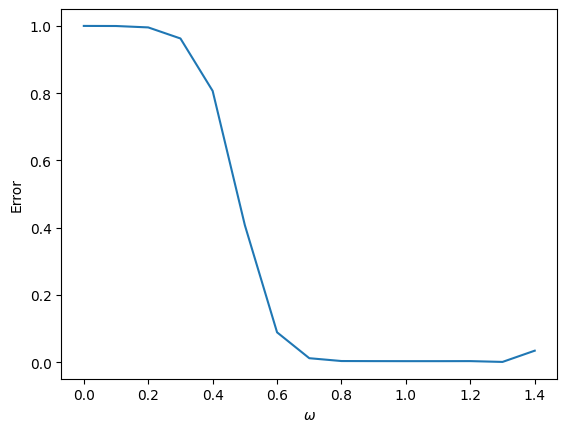

In [51]:
option = 'call'

if option == 'put':
    sign = -1
elif option == 'call':
    sign = 1

epsil = 1e-6
MaxIter = 10

Smax = 2000
dS = 40
dt = 0.25*T/100

price_bs = bs_price(S, K, r, T, sigma, option)

omega_array = np.arange(0.0,1.5,0.1)
error_array = []

for omega in omega_array:
    Put_IFD = American_Option_Implicit_GS_SOR(S, K, r, T, sigma, Smax, dS, dt, omega, epsil,MaxIter,option)
    S_IFD = Put_IFD[0]
    f_IFD = Put_IFD[1]
    price_IFD = Put_IFD[2]
    error_array.append(np.sqrt((price_IFD-price_bs)**2)/price_bs)

error_array = np.array(error_array)
plt.figure()
plt.plot(omega_array, error_array)
plt.xlabel(r'$\omega$')
plt.ylabel('Error')

We see that an $0.8 <\approx \omega <\approx 1.3 $ give an appropriate value. We will choose $\omega = 0.8$ for the proceeding work

### Adjusting the Resolution of the Price Grid

Here we fix the time grid resolution and vary that of the stock price. We investigate the stability and accuracy of the various finite-difference methods.

We first investigate the stabbility of the explicit approach:

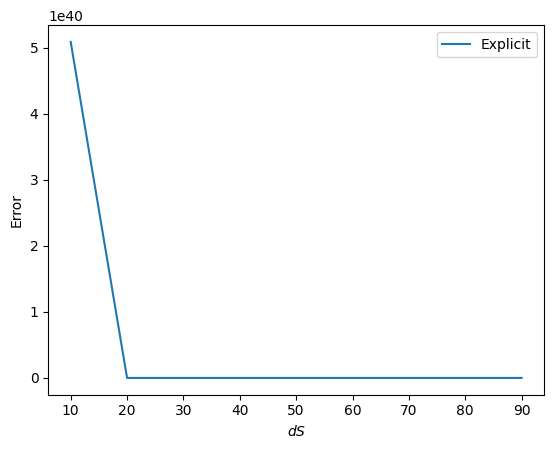

In [60]:
option = 'call'

if option == 'put':
    sign = -1
elif option == 'call':
    sign = 1

omega = 0.8
epsil = 1e-6
MaxIter = 1000

Smax = 2000
dt = T/100

price_bs = bs_price(S, K, r, T, sigma, option)

dS_array = np.arange(10,100,10)

error_array_Explicit = []
error_array_LU = []
error_array_GS = []
error_array_GS_SOR = []

for dS in dS_array:
    Call_Explicit = American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=0, dividend=0)[2]
    error_array_Explicit.append(np.sqrt((Call_Explicit-price_bs)**2)/price_bs)

plt.figure()
plt.plot(dS_array, error_array_Explicit, label='Explicit')
plt.xlabel(r'$dS$')
plt.ylabel('Error')
plt.legend()
plt.show()

We see that below $dS = 20$ the explicit method experiences significant instability, which is expected. Now, we investigate the implicit methods.

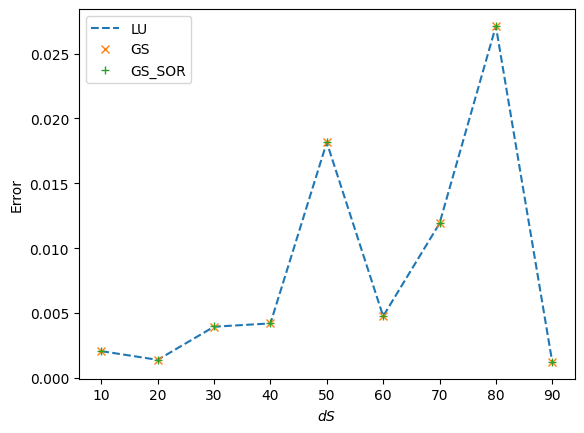

In [66]:
option = 'call'

if option == 'put':
    sign = -1
elif option == 'call':
    sign = 1

omega = 0.8
epsil = 1e-6
MaxIter = 1000

Smax = 2000
dt = T/100

price_bs = bs_price(S, K, r, T, sigma, option)

dS_array = np.arange(10,100,10)

error_array_Explicit = []
error_array_LU = []
error_array_GS = []
error_array_GS_SOR = []

for dS in dS_array:
    Call_LU = American_Option_Implicit_LU(S, K, r, T, sigma, Smax, dS, dt, option)[2]
    Call_GS = American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=0, dividend=0)[2]
    Call_GS_SOR = American_Option_Implicit_GS_SOR(S, K, r, T, sigma, Smax, dS, dt, omega, epsil,MaxIter,option)[2]
    
    
    error_array_LU.append(np.sqrt((Call_LU-price_bs)**2)/price_bs)
    error_array_GS.append(np.sqrt((Call_GS-price_bs)**2)/price_bs)
    error_array_GS_SOR.append(np.sqrt((Call_GS_SOR-price_bs)**2)/price_bs)


plt.figure()
plt.plot(dS_array, error_array_LU, '--',label='LU')
plt.plot(dS_array, error_array_GS, 'x',label='GS')
plt.plot(dS_array, error_array_GS_SOR, '+',label='GS_SOR')
plt.xlabel(r'$dS$')
plt.ylabel('Error')
plt.legend()
plt.show()

We see that the implicit methods remain stable across the range of $dS$

### Adjusting the Resolution of the Time Grid

Here we fix the time grid resolution and vary that of the stock price. We investigate the stability and accuracy of the various finite-difference methods.

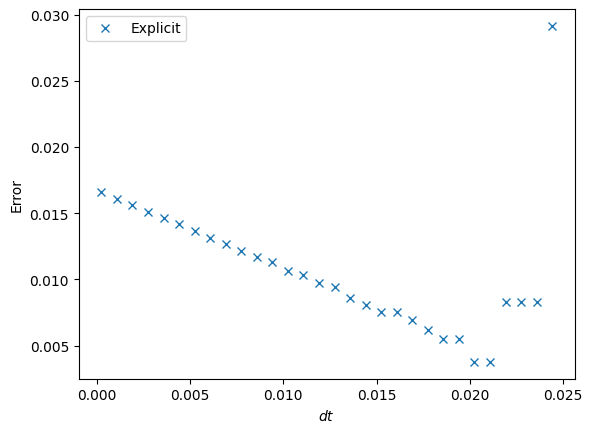

In [79]:
option = 'call'

if option == 'put':
    sign = -1
elif option == 'call':
    sign = 1

omega = 0.8
epsil = 1e-6
MaxIter = 1000

Smax = 2000
dS = 50

price_bs = bs_price(S, K, r, T, sigma, option)

dt_array = np.arange(T/1000,T/10,T/300)

error_array_Explicit = []

for dt in dt_array:
    Call_Explicit = American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=0, dividend=0)[2]
    error_array_Explicit.append(np.sqrt((Call_Explicit-price_bs)**2)/price_bs)

plt.figure()
plt.plot(dt_array, error_array_Explicit, 'x',label='Explicit')
plt.xlabel(r'$dt$')
plt.ylabel('Error')
plt.legend()
plt.show()

We see that the explicit method is less affected by changes in time resolution, however, increasing the resolution of the grid(decreasiing dt) does increase errors slightly

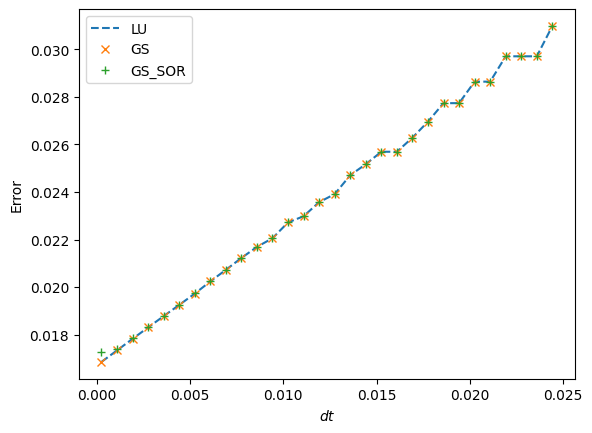

In [81]:
option = 'call'

if option == 'put':
    sign = -1
elif option == 'call':
    sign = 1

omega = 0.8
epsil = 1e-6
MaxIter = 1000

Smax = 2000
dS = 50

price_bs = bs_price(S, K, r, T, sigma, option)

dt_array = np.arange(T/1000,T/10,T/300)

error_array_Explicit = []
error_array_LU = []
error_array_GS = []
error_array_GS_SOR = []

for dt in dt_array:
    Call_LU = American_Option_Implicit_LU(S, K, r, T, sigma, Smax, dS, dt, option)[2]
    Call_GS = American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=0, dividend=0)[2]
    Call_GS_SOR = American_Option_Implicit_GS_SOR(S, K, r, T, sigma, Smax, dS, dt, omega, epsil,MaxIter,option)[2]
    
    
    error_array_LU.append(np.sqrt((Call_LU-price_bs)**2)/price_bs)
    error_array_GS.append(np.sqrt((Call_GS-price_bs)**2)/price_bs)
    error_array_GS_SOR.append(np.sqrt((Call_GS_SOR-price_bs)**2)/price_bs)

plt.figure()
plt.plot(dt_array, error_array_LU, '--',label='LU')
plt.plot(dt_array, error_array_GS, 'x',label='GS')
plt.plot(dt_array, error_array_GS_SOR, '+',label='GS_SOR')
plt.xlabel(r'$dt$')
plt.ylabel('Error')
plt.legend()
plt.show()

When investigating the implicit methods, we find a decreasing error as the resolution is increased, as expected.

Choosing $dt = T/1000$ and $dS = 30$, lets compare call and put prices to their respective Black-Scholes prices:

In [84]:
option = 'call'

if option == 'put':
    sign = -1
elif option == 'call':
    sign = 1

omega = 0.8
epsil = 1e-6
MaxIter = 1000

Smax = 2000
dS = 30
dt = T/1000

price_bs = bs_price(S, K, r, T, sigma, option)

Call_Explicit = American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=0, dividend=0)[2]
error_Explicit = (np.sqrt((Call_Explicit-price_bs)**2)/price_bs)

Call_LU = American_Option_Implicit_LU(S, K, r, T, sigma, Smax, dS, dt, option)[2]
Call_GS = American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=0, dividend=0)[2]
Call_GS_SOR = American_Option_Implicit_GS_SOR(S, K, r, T, sigma, Smax, dS, dt, omega, epsil,MaxIter,option)[2]

error_LU = (np.sqrt((Call_LU-price_bs)**2)/price_bs)
error_GS = (np.sqrt((Call_GS-price_bs)**2)/price_bs)
error_GS_SOR = (np.sqrt((Call_GS_SOR-price_bs)**2)/price_bs)

print(f"Explicit Call Price = {Call_Explicit} with error {error_Explicit}")
print(f"LU Call Price = {Call_LU} with error {error_LU}")
print(f"GS Call Price = {Call_GS} with error {error_GS}")
print(f"GS SOR Call Price = {Call_GS_SOR} with error {error_GS_SOR}")

Explicit Call Price = 45.05406674172064 with error 0.002396291800003065
LU Call Price = 45.0412874836551 with error 0.0026792548298958667
GS Call Price = 45.03723263743883 with error 0.0027690387254256845
GS SOR Call Price = 45.01345225557744 with error 0.003295592682548538


We see that when we avoid the conditional instability of the explicit method, it has a lower error for call pricing comapred to the implicit methods 

In [86]:
option = 'put'

if option == 'put':
    sign = -1
elif option == 'call':
    sign = 1

omega = 0.8
epsil = 1e-6
MaxIter = 1000

Smax = 2000
dS = 30
dt = T/1000

price_bs = bs_price(S, K, r, T, sigma, option)

Call_Explicit = American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=0, dividend=0)[2]
error_Explicit = (np.sqrt((Call_Explicit-price_bs)**2)/price_bs)

Call_LU = American_Option_Implicit_LU(S, K, r, T, sigma, Smax, dS, dt, option)[2]
Call_GS = American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=0, dividend=0)[2]
Call_GS_SOR = American_Option_Implicit_GS_SOR(S, K, r, T, sigma, Smax, dS, dt, omega, epsil,MaxIter,option)[2]


print("Black-Scholes Put Price = ", price_bs)
print(f"Explicit Put Price = {Call_Explicit} ")
print(f"LU Put Price = {Call_LU} ")
print(f"GS Put Price = {Call_GS} ")
print(f"GS SOR Put Price = {Call_GS_SOR}")

Black-Scholes Put Price =  79.5298253471708
Explicit Put Price = 81.61777734498764 
LU Put Price = 81.59468121116804 
GS Put Price = 81.59507358386595 
GS SOR Put Price = 81.57491520621856


## Pricing with a Dividend Payment

We investigate dividend payments of $4\%$ and $10\%$ for the binomial, explicit, and Gauss-Seidel methods.

### $q = 4\%$

In [88]:
div = 0.04
div_time = T/2

In [93]:
option='call' 
print("American Call Binomial Price = ",Binomial_American_Option_Dividend(S, K, r, T, sigma, dividend=0, dividend_time=0, n=1000, option='call'), "\n")
print("American Call Binomial Price with Dividend = ",Binomial_American_Option_Dividend(S, K, r, T, sigma, dividend=div, dividend_time=div_time, n=1000, option='call'), "\n")

print("American Call Explicit Price = ",American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=0, dividend=0)[2], "\n")
print("American Call Explicit Price with Dividend = ",American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=div_time, dividend=div)[2], "\n")

epsil = 1e-6
MaxIter = 1000
print("American Call GS Price = ",American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=0, dividend=0)[2], "\n")
print("American Call GS Price with Dividend = ",American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=div_time, dividend=div)[2], "\n")

American Call Binomial Price =  45.13817091623564 

American Call Binomial Price with Dividend =  29.705252733746256 

American Call Explicit Price =  45.05406674172064 

American Call Explicit Price with Dividend =  32.044058984159335 

American Call GS Price =  45.03723263743883 

American Call GS Price with Dividend =  32.0407922925602 



In [94]:
option='put' 
print("American Put Binomial Price = ",Binomial_American_Option_Dividend(S, K, r, T, sigma, dividend=0, dividend_time=0, n=1000, option='put'), "\n")
print("American Put Binomial Price with Dividend = ",Binomial_American_Option_Dividend(S, K, r, T, sigma, dividend=div, dividend_time=div_time, n=1000, option='put'), "\n")

print("American Put Explicit Price = ",American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=0, dividend=0)[2], "\n")
print("American Put Explicit Price with Dividend = ",American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=div_time, dividend=div)[2], "\n")

epsil = 1e-6
MaxIter = 1000
print("American Put GS Price = ",American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=0, dividend=0)[2], "\n")
print("American Put GS Price with Dividend = ",American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=div_time, dividend=div)[2], "\n")

American Put Binomial Price =  81.78801197453275 

American Put Binomial Price with Dividend =  107.18758930648916 

American Put Explicit Price =  81.61777734498764 

American Put Explicit Price with Dividend =  108.81840164558199 

American Put GS Price =  81.59507358386595 

American Put GS Price with Dividend =  108.8076188277395 



We can see that introducing a dividend decreases the price of the call and increases the price of the put. This is because we are effectively reducing the value of the stock while under the option contract.

### $q = 10\%$

In [96]:
div = 0.1
div_time = T/2

In [97]:
option='call' 
print("American Call Binomial Price = ",Binomial_American_Option_Dividend(S, K, r, T, sigma, dividend=0, dividend_time=0, n=1000, option='call'), "\n")
print("American Call Binomial Price with Dividend = ",Binomial_American_Option_Dividend(S, K, r, T, sigma, dividend=div, dividend_time=div_time, n=1000, option='call'), "\n")

print("American Call Explicit Price = ",American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=0, dividend=0)[2], "\n")
print("American Call Explicit Price with Dividend = ",American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=div_time, dividend=div)[2], "\n")

epsil = 1e-6
MaxIter = 1000
print("American Call GS Price = ",American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=0, dividend=0)[2], "\n")
print("American Call GS Price with Dividend = ",American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=div_time, dividend=div)[2], "\n")

American Call Binomial Price =  45.13817091623564 

American Call Binomial Price with Dividend =  13.918517283552665 

American Call Explicit Price =  45.05406674172064 

American Call Explicit Price with Dividend =  18.2859457870488 

American Call GS Price =  45.03723263743883 

American Call GS Price with Dividend =  18.298419354515268 



In [98]:
option='put' 
print("American Put Binomial Price = ",Binomial_American_Option_Dividend(S, K, r, T, sigma, dividend=0, dividend_time=0, n=1000, option='put'), "\n")
print("American Put Binomial Price with Dividend = ",Binomial_American_Option_Dividend(S, K, r, T, sigma, dividend=div, dividend_time=div_time, n=1000, option='put'), "\n")

print("American Put Explicit Price = ",American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=0, dividend=0)[2], "\n")
print("American Put Explicit Price with Dividend = ",American_Option_Explicit_Dividend(S, K, r, T, sigma, Smax, dS, dt, option, dividend_time=div_time, dividend=div)[2], "\n")

epsil = 1e-6
MaxIter = 1000
print("American Put GS Price = ",American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=0, dividend=0)[2], "\n")
print("American Put GS Price with Dividend = ",American_Option_Implicit_GS_Dividend(S, K, r, T, sigma, Smax, dS, dt, epsil, MaxIter, option, dividend_time=div_time, dividend=div)[2], "\n")

American Put Binomial Price =  81.78801197453275 

American Put Binomial Price with Dividend =  153.57016337452282 

American Put Explicit Price =  81.61777734498764 

American Put Explicit Price with Dividend =  156.15195021774096 

American Put GS Price =  81.59507358386595 

American Put GS Price with Dividend =  156.15518056739646 



Increasing the dividend payment further decreases the call price and further increases the put price, intuitively.

# Conclusions

To conclude, we developed various methods of calculating American call and put prices. Of these methods, the implicit methods are most promising as they remain stable, in comparison to explicit methods, when increasing the resolution of the finite-difference grids, thus being more accurate. The binomial model is also good, but can have a high computational cost and it's performance tends to plateau when increasing the number of nodes.

An optimal $\omega \approx 0.8$ was also found for the succesive over-relaxation Gauss-Seidel method.

We also found that introducing a dividend payment decreased the call price and increased the put price as expected.